In [1]:
import sqlite3
import pandas as pd
import tensorflow as tf

# Load the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

# Get the word index mapping
word_index = tf.keras.datasets.imdb.get_word_index()

# Add special tokens to word index
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

# Reverse the word index
reverse_word_index = {value: key for key, value in word_index.items()}

# Decode reviews
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i, "?") for i in encoded_review])

# Decode training data
decoded_train_reviews = [decode_review(review) for review in train_data]
decoded_test_reviews = [decode_review(review) for review in test_data]

# Create a DataFrame for the train data
train_df = pd.DataFrame({
    "review": decoded_train_reviews,
    "label": train_labels
})

# Create a DataFrame for the test data
test_df = pd.DataFrame({
    "review": decoded_test_reviews,
    "label": test_labels
})

# Save the data to SQLite
conn = sqlite3.connect("imdb_reviews.db")
train_df.to_sql("train_reviews", conn, if_exists="replace", index=False)
test_df.to_sql("test_reviews", conn, if_exists="replace", index=False)

print("Data saved to SQLite database 'imdb_reviews.db'.")


Data saved to SQLite database 'imdb_reviews.db'.


In [2]:
# Example: Query data from SQLite
query = """
SELECT review, label
FROM train_reviews
WHERE label = 1
LIMIT 5;
"""

positive_reviews = pd.read_sql(query, conn)
print("Positive reviews:\n", positive_reviews)

Positive reviews:
                                               review  label
0  <START> this film was just brilliant casting l...      1
1  <START> the <UNK> <UNK> at storytelling the tr...      1
2  <START> lavish production values and solid per...      1
3  <START> just got out and cannot believe what a...      1
4  <START> french horror cinema has seen somethin...      1


## Analysis
### 1. Preprocess Data for TensorFlow

In [3]:
# Load training data from SQLite
train_query = "SELECT * FROM train_reviews;"
train_data_sql = pd.read_sql(train_query, conn)

# Load testing data from SQLite
test_query = "SELECT * FROM test_reviews;"
test_data_sql = pd.read_sql(test_query, conn)

# Extract reviews and labels
train_reviews = train_data_sql["review"].tolist()
train_labels = train_data_sql["label"].tolist()

test_reviews = test_data_sql["review"].tolist()
test_labels = test_data_sql["label"].tolist()

# Tokenize and pad sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_reviews)

train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

# Pad sequences
train_data_padded = pad_sequences(train_sequences, maxlen=256, padding="post", truncating="post")
test_data_padded = pad_sequences(test_sequences, maxlen=256, padding="post", truncating="post")


### 2. Train the Model

In [4]:
import numpy as np

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

model = Sequential([
    Embedding(10000, 16),                  # Embedding layer
    GlobalAveragePooling1D(),             # Pooling layer
    Dense(16, activation="relu"),         # Hidden layer
    Dense(1, activation="sigmoid")        # Output layer
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_data_padded,
    train_labels,
    epochs=10,
    batch_size=512,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5290 - loss: 0.6911 - val_accuracy: 0.6774 - val_loss: 0.6799
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6212 - loss: 0.6752 - val_accuracy: 0.7278 - val_loss: 0.6528
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7250 - loss: 0.6425 - val_accuracy: 0.7714 - val_loss: 0.6069
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7650 - loss: 0.5924 - val_accuracy: 0.7982 - val_loss: 0.5507
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8048 - loss: 0.5293 - val_accuracy: 0.8190 - val_loss: 0.4939
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8250 - loss: 0.4739 - val_accuracy: 0.8160 - val_loss: 0.4543
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8326 - loss: 0.4263 - val_accuracy: 0.8428 - val_loss: 0.4134
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8498 - loss: 0.3919 - val_accuracy: 0.8508 - v

### 3. Query for Insights

In [5]:
# Query to count positive and negative reviews
query = """
SELECT label, COUNT(*) AS count
FROM train_reviews
GROUP BY label;
"""

label_distribution = pd.read_sql(query, conn)
print("Label distribution:\n", label_distribution)

Label distribution:
    label  count
0      0  12500
1      1  12500


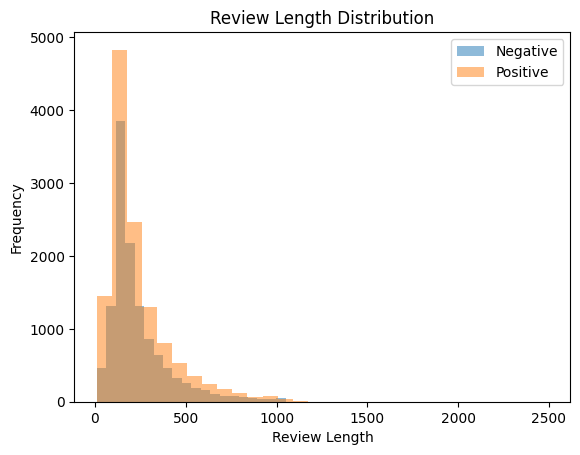

In [6]:
import matplotlib.pyplot as plt

# Calculate the length of each review
train_data_sql['review_length'] = train_data_sql['review'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.hist(train_data_sql[train_data_sql['label'] == 0]['review_length'], bins=30, alpha=0.5, label='Negative')
plt.hist(train_data_sql[train_data_sql['label'] == 1]['review_length'], bins=30, alpha=0.5, label='Positive')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Review Length Distribution')
plt.legend()
plt.show()